In [118]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import loader
import neuralnet
%aimport neuralnet
%aimport loader
%aimport

Modules to reload:
loader neuralnet

Modules to skip:



# Problem 1

$ y_0 = 784x1, y_1 = 200x1, y_2 = 10 x 1$

$z_1 = 200x1, z_2 = 10 x 1$

$b_1 = 200x1, b_2 = 10 x 1$

$w_1 = 784x200, w_2 =  200x1$

$g = \dfrac{1}{1 + e^{-z}}$

$t = tanh(z)$

Rather than adding a neuron, I've elected to just add an arbitrary, updating value to each $z$. Which is equivalent to adding another neuron.

$$\dfrac{\partial L}{w^l} = y^{l-1} \dfrac{\partial L}{\partial z^l}^T$$

$$\dfrac{\partial L}{w^2} = y^{1} \dfrac{\partial L}{\partial z^2}^T$$
$$ = y^1 (diag(g'(z^2 + b^2)) \cdot \dfrac{\partial L}{\partial y^2})^T$$

$$ w^2 \leftarrow w^2 - \eta * \dfrac{\partial L}{w^2}$$

$$\dfrac{\partial L}{w^1} = y^{0} \dfrac{\partial L}{\partial z^1}^T$$
$$ = y^0 (diag(t'(z^1 + b^1)) \cdot \dfrac{\partial L}{\partial y^1})^T$$
$$ = y^0 (diag(t'(z^1 + b^1)) \cdot w^2 \cdot \dfrac{\partial L}{\partial z^2})^T$$

$$ w^1 \leftarrow w^1 - \eta * \dfrac{\partial L}{w^l}$$

The benefit of backprop is being able to cache the results from the previous delta.

### Squared Loss:

$$\dfrac{\partial L}{w^l} = y^0 (diag( 1 - tanh^2(z^1 + b^1)) \cdot w^2 \cdot (diag(g(z^2 + b^2)(1 - g(z^2 + b^2))) \cdot (y^2 - y)))^T$$

$$\dfrac{\partial L}{w^2} = y^1 (diag(g(z^2 + b^2)(1 - g(z^2 + b^2)) \cdot (y^2 - y)))^T$$

### Cross-Entropy Loss:

$$\dfrac{\partial L}{w^l} = y^0 (diag( 1 - tanh^2(z^1 + b^1)) \cdot w^2 \cdot (diag(g(z^2 + b^2)(1 - g(z^2 + b^2))) \cdot -(\dfrac{y}{y^2}- \dfrac{1 - y}{1 - y^2})))^T$$

$$\dfrac{\partial L}{w^2} = y^1 (diag(g(z^2 + b^2)(1 - g(z^2 + b^2)) \cdot-(\dfrac{y}{y^2}- \dfrac{1 - y}{1 - y^2})))^T$$


In [198]:
def squared_error(y, y_hat):
    return (y - y_hat).dot((y - y_hat))

def squared_error_prime(y, y_hat):
    return -1 * (y - y_hat)

def cross_ent(y, y_hat):
    part1 = y.dot(np.log(y_hat))
    part2 = (1.0 - y).dot(np.nan_to_num(np.log(1.0 - y_hat)))
    return -(part1 + part2)

def cross_ent_prime(y, y_hat):
    part1 = y / y_hat
    part2 = (1 - y)/(1 - y_hat)
    return -(part1 - part2)
    
def t(z):
    return np.tanh(z)

def t_prime(z):
    return 1 - np.power(t(z), 2)

def g(z):
    return (1.0 / (1.0 + np.exp(-z)))

def g_prime(z):
    return g(z) * (1 - g(z))

Total Train Time 0.058928
{'num_iters': 100, 'end': datetime.datetime(2015, 11, 22, 19, 32, 23, 984451), 'start': datetime.datetime(2015, 11, 22, 19, 32, 23, 925523)}


/Users/bill_chambers/AeroFS/Dev/ml289/hw6/neuralnet.py:109: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


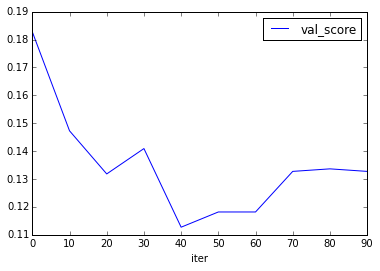

In [206]:
%autoreload
X, y = loader.fake_data()
input_dim = len(X[0])
output_dim = len(y[0])
hl_size = 50
layer1 = neuralnet.Layer((input_dim, hl_size), t, t_prime)
layer2 = neuralnet.OutputLayer((hl_size, output_dim), g, g_prime)
nn = neuralnet.NeuralNet(layer1, layer2, cross_ent, cross_ent_prime)
nn.train(X, y, XVal=X, yVal=y, num_iters=100)
print(nn.train_params)
nn.resulting_scores()[['val_score', 'iter']].plot(x='iter')

# Problem 2

1. Parameters are inline below, weights are initialized normally around $\mu = 1, \sigma=0.01$
2. Training and Validation Accuracies are listed below.
3. Train time is listed below.
4. Plots are below. I only report every 20,000 iterations.
5. The cross entropy seemed to perform much better. Simply in terms of the equation it seems to be a more sophisticated measure of the loss. Therefore we could expect it to perform better. This aligned with the results, as it allowed me to descend faster and get to a much smaller error rate overall.

Kaggle Score for 200k iterations, 0.01 learning rate, squared loss = .929

Kaggle Score for 200k iterations, 0.01 learning rate, cross entropy loss = 

*it's interesting to note that these had the exact same initialization values (for w's)*

In [221]:
train_dict = loader.load_training_data() # loader.py
X = train_dict['X']
y = train_dict['y']
print("Mean of y:", y.mean())
y = pd.get_dummies(y).values

XVal = train_dict['XVal']
yVal = pd.get_dummies(train_dict['yVal']).values

print("Num Training Examples:", len(X))

Mean of y: 4.44715555556
Num Trainings 45000


## Squared Error Loss

In [232]:
%autoreload
input_dim = len(X[0])
output_dim = len(y[0])
hl_size = 200

layer1 = neuralnet.Layer((input_dim, hl_size), t, t_prime)
layer2 = neuralnet.OutputLayer((hl_size, output_dim), g, g_prime)

nn = neuralnet.NeuralNet(layer1, layer2, squared_error, squared_error_prime)
nn.train(X, y, num_iters=200000, score_every=20000, eta=0.01, XVal=XVal, yVal=yVal)

Total Train Time 356.77 Seconds


/Users/bill_chambers/AeroFS/Dev/ml289/hw6/neuralnet.py:109: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if XVal != None:


Parameters used {'score_every': 20000, 'num_iters': 200000, 'eta': 0.01, 'end': datetime.datetime(2015, 11, 22, 20, 44, 47, 953189), 'start': datetime.datetime(2015, 11, 22, 20, 38, 51, 182716)}
Training Accuracy 0.0680666666667
Validation Accuracy 0.074


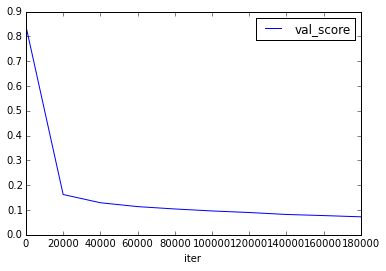

In [233]:
print("Parameters used", nn.train_params)
nn.resulting_scores()[['val_score', 'iter']].plot(x='iter')
print("Training Accuracy", nn.score(X,y)/len(X))
print("Validation Accuracy", nn.score(XVal,yVal)/len(XVal))

## Cross Entropy Loss


In [222]:
%autoreload
input_dim = len(X[0])
output_dim = len(y[0])
hl_size = 200

layer1 = neuralnet.Layer((input_dim, hl_size), t, t_prime)
layer2 = neuralnet.OutputLayer((hl_size, output_dim), g, g_prime)

nn = neuralnet.NeuralNet(layer1, layer2, cross_ent, cross_ent_prime)
nn.train(X, y, num_iters=200000, score_every=20000, eta=0.01, XVal=XVal, yVal=yVal)

Total Train Time 345.30 Seconds


/Users/bill_chambers/AeroFS/Dev/ml289/hw6/neuralnet.py:109: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


Parameters used {'score_every': 20000, 'num_iters': 200000, 'eta': 0.01, 'end': datetime.datetime(2015, 11, 22, 20, 33, 34, 499609), 'start': datetime.datetime(2015, 11, 22, 20, 27, 49, 198979)}
Training Accuracy 0.015
Validation Accuracy 0.0328666666667


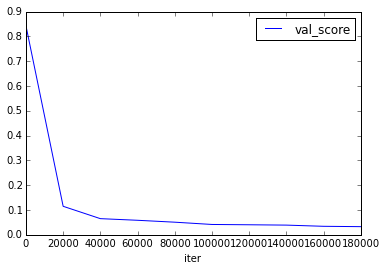

In [228]:
print("Parameters used", nn.train_params)
nn.resulting_scores()[['val_score', 'iter']].plot(x='iter')
print("Training Accuracy", nn.score(X,y)/len(X))
print("Validation Accuracy", nn.score(XVal,yVal)/len(XVal))

In [229]:
kaggleTest = loader.load_test_data()
preds = nn.predict(kaggleTest)
df = pd.DataFrame(preds).reset_index()
df.columns = ['id', 'category']
df.id = df.id + 1
df.to_csv("cross_ent 200000 iters.csv",index=None)